This notebook creates two subgraphs from the Booksampo SW, 
- one for novels written in Finnish, and 
- one for novels written in another language but translated into Finnish



In [1]:
# import packages

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST, TURTLE
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

ModuleNotFoundError: No module named 'constants'

In [2]:
# 
from rdflib import Graph

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')


In [3]:
# colors
import matplotlib.colors as mcolors
from matplotlib import cm
# set style
import seaborn as sns

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [11]:
# Query
Q = """
PREFIX rel: <http://ldf.fi/relse/>

CONSTRUCT {


?teos a rel:novel ;
    skos:prefLabel ?title ;
    rel:langOrig ?kieliuri ;
    rel:hasAuthor ?author ;
    rel:pubYear ?vuosi_ .


?author a rel:author ;
	skos:prefLabel ?authorname ;
	foaf:gender ?gender ;
	rel:authorNationality ?kansallisuusuri .

?kieliuri a rel:lang ;
	skos:prefLabel ?kieli .

?kansallisuusuri a rel:nationality ;
	skos:prefLabel ?kansallisuus. 

}

WHERE {

  ?teos a kaunokki:romaani ; skos:prefLabel ?title .
  ?teos kaunokki:alkukieli ?kieliuri .
  FILTER (?kieliuri !=  <http://lexvo.org/id/iso639-3/fin>  )
  OPTIONAL {?kieliuri skos:prefLabel ?kieli . }
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # käännetty suomeksi
  FILTER EXISTS {?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin>  }
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  BIND(xsd:integer(?vuosiluku) AS ?vuosi_)
  ?teos kaunokki:tekija ?author.
  ?author skos:prefLabel ?authorname .
OPTIONAL {?author kaunokki:kansallisuus ?kansallisuusuri . OPTIONAL { ?kansallisuusuri skos:prefLabel ?kansallisuus .} }
OPTIONAL  {?author foaf:gender ?gender }


} 
"""

In [12]:
# construct graph

# query graph
print('\n\n*** constructing the graph')
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")

sparql.setQuery(PREFIXES + Q)

sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])

sparql.setReturnFormat(TURTLE)
results = sparql.query().convert()



*** constructing the graph


In [13]:
# parse

from rdflib import Graph
g = Graph()
#g.parse(data=results, format="turtle") # "mygraph.ttl"
g.parse(data=results, format="turtle")

<Graph identifier=Ned7df86195fd4165929177493a1b5255 (<class 'rdflib.graph.Graph'>)>

In [54]:
# g correct
# foreign
g = Graph() #/u/98/peurat1/unix/Desktop/kirjasampo/data/graph2.ttl
#f.parse(data="../../data/finnish_graph2.nt", format="nt")

g.parse('../../data/nat_lang_graph.nt')

<Graph identifier=Nae544eb22f6243d2aabd69c1fd567e8c (<class 'rdflib.graph.Graph'>)>

In [55]:
# find all novels

from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

novels=[]
for s, p, o in g.triples((None,  None, None)):
    #print(o)
    if o ==rel.novel:
        #print(str(s))
        novels.append(str(s))
    #print(f"{s} is a  novel")
    
print("found" ,len(set(novels)), "novels")
print(novels[:5])


found 24963 novels
['http://data.kirjasampo.fi/abstractWork_4075992', 'http://www.btj.fi/at_1940412', 'http://www.yso.fi/onto/kaunokki#ateos_10798', 'http://www.yso.fi/onto/kaunokki#ateos_10504', 'http://seco.tkk.fi/saha3/ue050f94d-9aa5-4a3f-9cd6-4368c05f8c60']


In [17]:
# check turtschaninoff
novels=[]
for s, p, o in g.triples((None,  None, None)):
    #print(o)
    if str(s) =="http://data.kirjasampo.fi/abstractWork_9789513172398":
        print(s,p,o)
        #novels.append(str(s))
    #print(f"{s} is a  novel")
    


http://data.kirjasampo.fi/abstractWork_9789513172398 http://ldf.fi/relse/hasAuthor http://seco.tkk.fi/saha3/u407917fd-84d0-4ad5-a092-23a1ab44885a
http://data.kirjasampo.fi/abstractWork_9789513172398 http://ldf.fi/relse/langOrig http://lexvo.org/id/iso639-3/swe
http://data.kirjasampo.fi/abstractWork_9789513172398 http://www.w3.org/2004/02/skos/core#prefLabel Anaché
http://data.kirjasampo.fi/abstractWork_9789513172398 http://www.w3.org/2004/02/skos/core#prefLabel Anaché
http://data.kirjasampo.fi/abstractWork_9789513172398 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://ldf.fi/relse/novel
http://data.kirjasampo.fi/abstractWork_9789513172398 http://ldf.fi/relse/pubYear 2013


In [7]:
# title lookup

# query the database for novel titles

qres = g.query("""
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?id ?label
WHERE {
  ?id a rel:novel ; skos:prefLabel ?label
}  """)

title_lookup=dict([(str(url), str(label)) for url, label in qres])

list(title_lookup.items())[:10]

[('http://www.btj.fi/at_1678175', 'Petra Delicado ja merkityt tytöt'),
 ('http://data.kirjasampo.fi/abstractWork_9789518830927',
  'Piraatti-Pete ja hirmuiset merirosvot'),
 ('http://www.yso.fi/onto/kaunokki#ateos_9589', 'Ensimmäinen kotka'),
 ('http://www.yso.fi/onto/kaunokki#ateos_3912', 'Yön suojissa'),
 ('http://data.kirjasampo.fi/abstractWork_6834230', "The orphan's tale"),
 ('http://data.kirjasampo.fi/abstractWork_4124516', 'The ordinary princess'),
 ('http://www.yso.fi/onto/kaunokki#ateos_2216', 'Mieheni oli kommunisti'),
 ('http://data.kirjasampo.fi/abstractWork_9789511255659', 'Suden hetki'),
 ('http://seco.tkk.fi/saha3/ue552c4bb-ecd8-495d-be5d-00c45f9caaa8',
  'Matka avaruudessa'),
 ('http://seco.tkk.fi/saha3/ucf938d75-fc5e-4637-9715-73092ba5482a',
  'Kadonneet kaverukset')]

In [19]:
# gender lookup

qres = g.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?teos ?gender
WHERE {
  ?teos a rel:novel ; rel:hasAuthor ?author. 
  ?author foaf:gender ?gender .
}  """)

gender_lookup=defaultdict(set)
for url, label in qres:
    gender_lookup[str(url)].update([str(label)])
#print(list(gender_lookup.items())[-10:])
print(len(gender_lookup))
gender_lookup2 = {novel:"unk" for novel in novels if novel not in gender_lookup.keys() }
gender_lookup.update(gender_lookup2)
print(len(gender_lookup))
print(list(gender_lookup.items())[:10],list(gender_lookup.items())[-10:])

24389
24389
[('http://www.btj.fi/at_1678175', {'http://www.yso.fi/onto/kaunokki#female'}), ('http://data.kirjasampo.fi/abstractWork_9789518830927', {'http://www.yso.fi/onto/kaunokki#female'}), ('http://www.yso.fi/onto/kaunokki#ateos_9589', {'http://www.yso.fi/onto/kaunokki#male'}), ('http://www.yso.fi/onto/kaunokki#ateos_3912', {'http://www.yso.fi/onto/kaunokki#female'}), ('http://data.kirjasampo.fi/abstractWork_6834230', {'http://www.yso.fi/onto/kaunokki#female'}), ('http://data.kirjasampo.fi/abstractWork_4124516', {'http://www.yso.fi/onto/kaunokki#female'}), ('http://www.yso.fi/onto/kaunokki#ateos_2216', {'http://www.yso.fi/onto/kaunokki#male'}), ('http://data.kirjasampo.fi/abstractWork_9789511255659', {'http://www.yso.fi/onto/kaunokki#female'}), ('http://seco.tkk.fi/saha3/ue552c4bb-ecd8-495d-be5d-00c45f9caaa8', {'http://www.yso.fi/onto/kaunokki#male'}), ('http://seco.tkk.fi/saha3/u99617114-2455-49e4-8bed-05851eb04a3f', {'http://www.yso.fi/onto/kaunokki#male'})] [('http://seco.tkk.fi

# correct nationalities

In [18]:
# nationality lookup

qres = g.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?teos ?nationality
WHERE {
  ?teos a rel:novel ; rel:hasAuthor ?author. 
  ?author rel:authorNationality ?nationality .# ?nationality skos:prefLabel ?label.
  #FILTER (LANG(?label)="fi")
}  """)

#novelnat_lookup=dict([(str(url), str(label)) for url, label in qres])
#print(list(gender_lookup.items())[-10:])
import collections 

novelnat=defaultdict(set)
for url, label in qres:
    novelnat[str(url)].update([str(label)])
    
novelnat_lookup2 = {novel:"unk" for novel in novels if novel not in novelnat.keys() }
novelnat.update(novelnat_lookup2)
print(len(novelnat))
print(list(novelnat.items())[:10],list(novelnat.items())[-10:])

23549
[('http://www.btj.fi/at_1678175', {'http://www.yso.fi/onto/koko/p13629'}), ('http://data.kirjasampo.fi/abstractWork_9789518830927', {'http://www.yso.fi/onto/koko/p2224'}), ('http://www.yso.fi/onto/kaunokki#ateos_9589', {'http://www.yso.fi/onto/koko/p73101'}), ('http://www.yso.fi/onto/kaunokki#ateos_3912', {'http://www.yso.fi/onto/koko/p73101'}), ('http://data.kirjasampo.fi/abstractWork_6834230', {'http://www.yso.fi/onto/koko/p73101'}), ('http://www.yso.fi/onto/kaunokki#ateos_2216', {'http://www.yso.fi/onto/koko/p73101'}), ('http://data.kirjasampo.fi/abstractWork_9789511255659', {'http://www.yso.fi/onto/koko/p73101'}), ('http://seco.tkk.fi/saha3/ue552c4bb-ecd8-495d-be5d-00c45f9caaa8', {'http://www.yso.fi/onto/koko/p73101'}), ('http://seco.tkk.fi/saha3/ucf938d75-fc5e-4637-9715-73092ba5482a', {'http://www.yso.fi/onto/koko/p54872'}), ('http://seco.tkk.fi/saha3/u99617114-2455-49e4-8bed-05851eb04a3f', {'http://www.yso.fi/onto/koko/p3437'})] [('http://www.yso.fi/onto/kaunokki#ateos_2128

In [20]:
value_length=[]
for k,n in novelnat.items():
    if n== "unk":
        value_length.append(0)
    else:
        l = len(n)
        value_length.append(l)
max(value_length)
np.mean(value_length)
print("1:",value_length.count(1), " 0:",value_length.count(0))

1: 21573  0: 0


In [21]:
# nationality label lookup

qres = g.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?nationality (SAMPLE(?natlabel) AS ?natl)
WHERE {
  ?teos a rel:novel ; rel:hasAuthor ?author. 
  ?author rel:authorNationality ?nationality . ?nationality skos:prefLabel ?label.
  FILTER (LANG(?label)="fi")
  ?nationality skos:prefLabel ?labelAny.
  #BIND( "unk" as ?label2)
  BIND(COALESCE(?label, ?labelAny) AS ?natlabel )
} GROUP BY ?nationality
""")

nat_lookup=defaultdict(set)
for url, label in qres:
    nat_lookup[str(url)].update([str(label)])
    
#novelnat_lookup2 = {novel:"unk" for novel in novels if novel not in novelnat.keys() }
#novelnat.update(novelnat_lookup2)
#print(len(novelnat))
#print(list(novelnat.items())[:10],list(novelnat_lookup.items())[-10:])

#nat_lookup=dict([(str(url), str(label)) for url, label in qres])
#print(list(gender_lookup.items())[-10:])
#nat_lookup2 = {novel:"unk" for novel in novels if novel not in nat_lookup.keys() }
#nat_lookup.update(nat_lookup2)
print(len(nat_lookup))
print(list(nat_lookup.items())[:10],list(nat_lookup.items())[-10:])

152
[('http://www.yso.fi/onto/koko/p13629', {'espanjalaiset'}), ('http://www.yso.fi/onto/koko/p2224', {'britit'}), ('http://www.yso.fi/onto/koko/p73101', {'yhdysvaltalaiset'}), ('http://www.yso.fi/onto/koko/p54872', {'kanadalaiset'}), ('http://www.yso.fi/onto/koko/p3437', {'ranskalaiset'}), ('http://www.yso.fi/onto/koko/p745', {'saksalaiset'}), ('http://www.yso.fi/onto/koko/p14632', {'alankomaalaiset'}), ('http://www.yso.fi/onto/koko/p6292', {'tanskalaiset'}), ('http://www.yso.fi/onto/koko/p607', {'englantilaiset'}), ('http://seco.tkk.fi/saha3/u996eb3eb-230f-4dc5-b607-8f06acbf66ad', {'libanonilaiset'})] [('http://seco.tkk.fi/saha3/uae9f2b4b-bf6b-4b38-afbe-8d92fa84372c', {'makedonialaiset'}), ('http://seco.tkk.fi/saha3/u4d0f8bfc-1dc4-4d8b-886f-8c4430553d48', {'jamaikalaiset'}), ('http://www.yso.fi/onto/koko/p3295', {'baltit'}), ('http://www.yso.fi/onto/koko/p35074', {'marit'}), ('http://seco.tkk.fi/saha3/ud472f914-dcc0-4ec3-9753-7815d6b15b93', {'norsunluurannikkolaiset'}), ('http://www.

In [22]:
natlabel_lookup=defaultdict(set)
for url, label in qres:
    natlabel_lookup[str(label)].update([str(url)])

In [23]:
# check which nationalities have multiple uris
for k,v in natlabel_lookup.items():
    if len(v)> 1:
        print(k,sorted(v))

sveitsiläiset ['http://seco.tkk.fi/onto/toimo/nationalities/Swiss', 'http://www.yso.fi/onto/koko/p7934']
portugalilaiset ['http://seco.tkk.fi/saha3/ud33f4204-1c6d-40a1-a3ee-2a8158f56921', 'http://www.yso.fi/onto/koko/p52159']
itävaltalaiset ['http://seco.tkk.fi/onto/toimo/nationalities/Austrian', 'http://www.yso.fi/onto/koko/p5291']
skotit ['http://seco.tkk.fi/onto/toimo/nationalities/Scottish_Scots_', 'http://www.yso.fi/onto/koko/p16273']
unkarilaiset ['http://seco.tkk.fi/onto/toimo/nationalities/Hungarian', 'http://www.yso.fi/onto/koko/p34461']
ukrainalaiset ['http://seco.tkk.fi/onto/toimo/nationalities/Ukrainian', 'http://www.yso.fi/onto/koko/p9118']
irakilaiset ['http://seco.tkk.fi/saha3/u84b75979-9611-4eac-96b9-fec1d03bf051', 'http://www.yso.fi/onto/koko/p69907']


In [24]:
# correct these to the yso_code one
g2=g

allres=[]
for k,v in natlabel_lookup.items():
    if len(v)> 1:
        print(k,sorted(v))
        old= sorted(v)[0]
        new=sorted(v)[1]
        query="""
                 DELETE {?author rel:authorNationality <OLD> }
                 INSERT { ?author rel:authorNationality  <NEW> }
                 WHERE { ?author rel:authorNationality <OLD> }
                 """
        q=query.replace("OLD",old).replace("NEW",new)
        g2.update(q)
        #print("After second update:")
        qres = g2.query("""

        PREFIX rel: <http://ldf.fi/relse/> 
        PREFIX dct: <http://purl.org/dc/terms/>
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

        SELECT ?s ?o WHERE { ?author rel:authorNationality ?s . ?s skos:prefLabel ?o. }

        """)
        allres+=qres


sveitsiläiset ['http://seco.tkk.fi/onto/toimo/nationalities/Swiss', 'http://www.yso.fi/onto/koko/p7934']
portugalilaiset ['http://seco.tkk.fi/saha3/ud33f4204-1c6d-40a1-a3ee-2a8158f56921', 'http://www.yso.fi/onto/koko/p52159']
itävaltalaiset ['http://seco.tkk.fi/onto/toimo/nationalities/Austrian', 'http://www.yso.fi/onto/koko/p5291']
skotit ['http://seco.tkk.fi/onto/toimo/nationalities/Scottish_Scots_', 'http://www.yso.fi/onto/koko/p16273']
unkarilaiset ['http://seco.tkk.fi/onto/toimo/nationalities/Hungarian', 'http://www.yso.fi/onto/koko/p34461']
ukrainalaiset ['http://seco.tkk.fi/onto/toimo/nationalities/Ukrainian', 'http://www.yso.fi/onto/koko/p9118']
irakilaiset ['http://seco.tkk.fi/saha3/u84b75979-9611-4eac-96b9-fec1d03bf051', 'http://www.yso.fi/onto/koko/p69907']


In [25]:
# nationality label lookup 2

qres = g2.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?nationality (SAMPLE(?natlabel) AS ?natl)
WHERE {
  ?teos a rel:novel ; rel:hasAuthor ?author. 
  ?author rel:authorNationality ?nationality . ?nationality skos:prefLabel ?label.
  FILTER (LANG(?label)="fi")
  ?nationality skos:prefLabel ?labelAny.
  #BIND( "unk" as ?label2)
  BIND(COALESCE(?label, ?labelAny) AS ?natlabel )
} GROUP BY ?nationality
""")

nat_lookup2=defaultdict(set)
for url, label in qres:
    nat_lookup2[str(url)].update([str(label)])
    
#novelnat_lookup2 = {novel:"unk" for novel in novels if novel not in novelnat.keys() }
#novelnat.update(novelnat_lookup2)
#print(len(novelnat))
#print(list(novelnat.items())[:10],list(novelnat_lookup.items())[-10:])

#nat_lookup=dict([(str(url), str(label)) for url, label in qres])
#print(list(gender_lookup.items())[-10:])
#nat_lookup2 = {novel:"unk" for novel in novels if novel not in nat_lookup.keys() }
#nat_lookup.update(nat_lookup2)
print(len(nat_lookup2), len(nat_lookup))
print(list(nat_lookup2.items())[:10],list(nat_lookup2.items())[-10:])

145 152
[('http://www.yso.fi/onto/koko/p13629', {'espanjalaiset'}), ('http://www.yso.fi/onto/koko/p2224', {'britit'}), ('http://www.yso.fi/onto/koko/p73101', {'yhdysvaltalaiset'}), ('http://www.yso.fi/onto/koko/p54872', {'kanadalaiset'}), ('http://www.yso.fi/onto/koko/p3437', {'ranskalaiset'}), ('http://www.yso.fi/onto/koko/p745', {'saksalaiset'}), ('http://www.yso.fi/onto/koko/p14632', {'alankomaalaiset'}), ('http://www.yso.fi/onto/koko/p6292', {'tanskalaiset'}), ('http://www.yso.fi/onto/koko/p607', {'englantilaiset'}), ('http://seco.tkk.fi/saha3/u996eb3eb-230f-4dc5-b607-8f06acbf66ad', {'libanonilaiset'})] [('http://seco.tkk.fi/saha3/uae9f2b4b-bf6b-4b38-afbe-8d92fa84372c', {'makedonialaiset'}), ('http://seco.tkk.fi/saha3/u4d0f8bfc-1dc4-4d8b-886f-8c4430553d48', {'jamaikalaiset'}), ('http://www.yso.fi/onto/koko/p3295', {'baltit'}), ('http://www.yso.fi/onto/koko/p35074', {'marit'}), ('http://seco.tkk.fi/saha3/ud472f914-dcc0-4ec3-9753-7815d6b15b93', {'norsunluurannikkolaiset'}), ('http://

In [19]:
# check which nationalities still have multiple uris
for k,v in nat_lookup2.items():
    if len(v)> 1:
        print(k,sorted(v))
        
# none yay!

In [26]:
# natlabel lookup updated

natlabel_lookup2=defaultdict(set)
for url, label in qres:
    natlabel_lookup2[str(label)].update([str(url)])

In [27]:
#
#print(nat_lookup.values())
alist=[]
for n in nat_lookup.values():
    alist += list(n)
print(sorted(alist))
# remove: toimittajat, sotilaat

# update 
# amerikkalaiset = yhdysvaltalaiset
# yhdysvallat = yhdysvaltalaiset
# Uusi-Seelant = uusiseelantilaiset
# belgialainen = belgialaiset
# hollannin kieli = alankomaalaiset
# englannin kieli = britit

# eteläamerikkalaiset ??
mylist= [("amerikkalaiset","yhdysvaltalaiset"),("englantilaiset","britit"), ("Yhdysvallat","yhdysvaltalaiset"),("Uusi-Seelanti","uusiseelantilaiset"),
        ("belgialainen","belgialaiset"),("hollannin kieli","alankomaalaiset"),("englannin kieli","britit"),("Kroatia","kroaatit"),("skotit","britit"),("walesilaiset","britit")]

['Burundi', 'Kroatia', 'Päiväntasaajan Guinea', 'Uusi-Seelanti', 'Venezuelan', 'Yhdysvallat', 'afganistanilaiset', 'ahvenanmaalaiset', 'alankomaalaiset', 'albaanit', 'algerialaiset', 'amerikankuubalaiset', 'amerikansuomalaiset', 'amerikkalaiset', 'angolalaiset', 'argentiinalaiset', 'armenialaiset', 'assyrialaiset', 'australialaiset', 'azerbaidžanilaiset', 'baltit', 'bangladeshiläiset', 'baskit', 'belgialainen', 'belgialaiset', 'bolivialaiset', 'bosniahertsegovinalaiset', 'botswanalaiset', 'brasilialaiset', 'britit', 'bulgarialaiset', 'chileläiset', 'dominikaanilaiset', 'egyptiläiset', 'englannin kieli', 'englantilaiset', 'espanjalaiset', 'eteläafrikkalaiset', 'eteläamerikkalaiset', 'etiopialaiset', 'flaamit', 'färingit', 'georgialaiset', 'ghanalaiset', 'grönlantilaiset', 'guadeloupelaiset', 'guatemalalaiset', 'haitilaiset', 'hantit', 'hollannin kieli', 'indonesialaiset', 'inkeriläiset', 'intialaiset', 'irakilaiset', 'irakilaiset', 'iranilaiset', 'irlantilaiset', 'islantilaiset', 'israe

In [28]:
for o,n in mylist:
    old=list(natlabel_lookup2[o])
    new=list(natlabel_lookup2[n])
    print(o, old, n, new)
    query="""
                 DELETE {?author rel:authorNationality <OLD> }
                 INSERT { ?author rel:authorNationality  <NEW> }
                 WHERE { ?author rel:authorNationality <OLD> }
                 """
    q=query.replace("OLD",old[0]).replace("NEW",new[0])
    g2.update(q)
#http://www.yso.fi/onto/koko/p16273    

amerikkalaiset ['http://www.yso.fi/onto/koko/p15010'] yhdysvaltalaiset ['http://www.yso.fi/onto/koko/p73101']
englantilaiset ['http://www.yso.fi/onto/koko/p607'] britit ['http://www.yso.fi/onto/koko/p2224']
Yhdysvallat ['http://www.yso.fi/onto/koko/p63178'] yhdysvaltalaiset ['http://www.yso.fi/onto/koko/p73101']
Uusi-Seelanti ['http://www.yso.fi/onto/koko/p57497'] uusiseelantilaiset ['http://seco.tkk.fi/saha3/u30d7a0cf-b7d3-439c-9cbb-47fede6352fd']
belgialainen ['http://seco.tkk.fi/onto/toimo/nationalities/Belgian'] belgialaiset ['http://www.yso.fi/onto/koko/p7333']
hollannin kieli ['http://www.yso.fi/onto/koko/p13543'] alankomaalaiset ['http://www.yso.fi/onto/koko/p14632']
englannin kieli ['http://www.yso.fi/onto/koko/p15528'] britit ['http://www.yso.fi/onto/koko/p2224']
Kroatia ['http://www.yso.fi/onto/koko/p61314'] kroaatit ['http://www.yso.fi/onto/koko/p2100']
skotit ['http://www.yso.fi/onto/koko/p16273'] britit ['http://www.yso.fi/onto/koko/p2224']
walesilaiset ['http://seco.tkk.f

In [29]:
query="""
             DELETE {?author rel:authorNationality <OLD> }
             INSERT { ?author rel:authorNationality  <NEW> }
             WHERE { ?author rel:authorNationality <OLD> }
             """
#q=query.replace("OLD","http://www.yso.fi/onto/koko/p16273").replace("NEW",'http://www.yso.fi/onto/koko/p2224')
#g2.update(q)

In [30]:
# delete no-nationalities

for v in ["toimittajat","sotilaat","jännityskirjallisuus"]:
    old=list(natlabel_lookup[v])
    #new=list(natlabel_lookup[n])
    print(old)
    query="""
                 DELETE {?author rel:authorNationality <OLD> }
                 #INSERT { ?author rel:authorNationality  <NEW> }
                 WHERE { ?author rel:authorNationality <OLD> }
                 """
    q=query.replace("OLD",old[0])#.replace("NEW",new[0])
    g2.update(q)

['http://www.yso.fi/onto/koko/p35181']
['http://www.yso.fi/onto/koko/p31721']
['http://www.yso.fi/onto/koko/p1750']


In [31]:
qres = g2.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?teos ?author ?nationality ?label
WHERE {
  ?teos a rel:novel ; rel:hasAuthor ?author. 
  ?author rel:authorNationality ?nationality . OPTIONAL {?nationality skos:prefLabel ?label.}
  ?author rel:authorNationality <http://www.yso.fi/onto/koko/p15010> .

} GROUP BY ?nationality ?teos ?author ?label
""")


for r in qres:
    print(r, "\n")

In [32]:
# count different values

qres = g2.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?teos ?nationality
WHERE {
  ?teos a rel:novel ; rel:hasAuthor ?author. 
  ?author rel:authorNationality ?nationality .# ?nationality skos:prefLabel ?label.
  #FILTER (LANG(?label)="fi")
}  """)

#novelnat_lookup=dict([(str(url), str(label)) for url, label in qres])
#print(list(gender_lookup.items())[-10:])
import collections 

novelnat=defaultdict(set)
for url, label in qres:
    novelnat[str(url)].update([str(label)])
    
novelnat_lookup2 = {novel:"unk" for novel in novels if novel not in novelnat.keys() }
novelnat.update(novelnat_lookup2)
print(len(novelnat))
print(list(novelnat.items())[:10],list(novelnat_lookup2.items())[-10:])

23549
[('http://www.btj.fi/at_1678175', {'http://www.yso.fi/onto/koko/p13629'}), ('http://data.kirjasampo.fi/abstractWork_9789518830927', {'http://www.yso.fi/onto/koko/p2224'}), ('http://www.yso.fi/onto/kaunokki#ateos_9589', {'http://www.yso.fi/onto/koko/p73101'}), ('http://www.yso.fi/onto/kaunokki#ateos_3912', {'http://www.yso.fi/onto/koko/p73101'}), ('http://data.kirjasampo.fi/abstractWork_6834230', {'http://www.yso.fi/onto/koko/p73101'}), ('http://www.yso.fi/onto/kaunokki#ateos_2216', {'http://www.yso.fi/onto/koko/p73101'}), ('http://data.kirjasampo.fi/abstractWork_9789511255659', {'http://www.yso.fi/onto/koko/p73101'}), ('http://seco.tkk.fi/saha3/ue552c4bb-ecd8-495d-be5d-00c45f9caaa8', {'http://www.yso.fi/onto/koko/p73101'}), ('http://seco.tkk.fi/saha3/ucf938d75-fc5e-4637-9715-73092ba5482a', {'http://www.yso.fi/onto/koko/p54872'}), ('http://seco.tkk.fi/saha3/u99617114-2455-49e4-8bed-05851eb04a3f', {'http://www.yso.fi/onto/koko/p3437'})] []


In [33]:
countdict=defaultdict(int)

for k,v in novelnat.items():
    if v == "unk":
        countdict[v] +=1
    else:
        for val in v:
            label=list(nat_lookup[val])
            #print(label)
            if len(label) ==1:
                countdict[label[0]] += 1


In [34]:
pd.DataFrame(countdict.items()).sort_values(by=1,ascending=False).head(30)

,0,1
2,yhdysvaltalaiset,6993
1,britit,5664
9,ruotsalaiset,2840
4,ranskalaiset,1166
5,saksalaiset,1088
13,norjalaiset,844
10,suomalaiset,744
15,venäläiset,569
7,tanskalaiset,532
3,kanadalaiset,456


In [35]:
# count how many works we have to compare with the earlier version

Q_kans ="""
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?kansallisuus (SAMPLE(?klabel) AS ?label) (COUNT(DISTINCT ?author) as ?authorcount) WHERE {
  
  ?teos  a rel:novel ; rel:hasAuthor ?author .
  #?teos kaunokki:manifests_in ?julkaisu .
  ?teos rel:pubYear ?vuosi . #?vuosi skos:prefLabel ?vuosiluku .
  BIND(regex(str(?vuosi), "199" ) AS ?decade)
  FILTER(?decade = xsd:boolean("true"))
  ?author rel:authorNationality ?kansallisuus . OPTIONAL { ?kansallisuus skos:prefLabel ?klabel FILTER(LANG(?klabel)="fi") }
  } GROUP BY ?kansallisuus
ORDER BY DESC(xsd:integer(?authorcount))
"""

decades=[190,191,192,193,194,195,196,197,198,199,200,201]

qres = g2.query(Q_kans)

In [36]:
df_kans=pd.DataFrame()
for d in decades:
    print(d)
    #sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")
    q=Q_kans.replace("199",str(d))
    qres = g2.query(q)
    for row in qres:
        nat = str(row.asdict()['kansallisuus'].toPython())   
        natname = str(row.asdict()['label'].toPython())   
        a = str(row.asdict()['authorcount'].toPython()) 
        temp=pd.DataFrame({"nationality":nat,"nlabel":natname,"authors":a}.values() ).T.rename({0:"nationality",1:"nlabel",2:"authors"},axis=1)
        temp["decade"] = d*10
        df_kans=pd.concat([df_kans,temp])
df_kans

190
191
192
193
194
195
196
197
198
199
200
201


,nationality,nlabel,authors,decade
0,http://www.yso.fi/onto/koko/p745,saksalaiset,36,1900
0,http://www.yso.fi/onto/koko/p2224,britit,22,1900
0,http://www.yso.fi/onto/koko/p16897,ruotsalaiset,21,1900
0,http://www.yso.fi/onto/koko/p3437,ranskalaiset,19,1900
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,14,1900
...,...,...,...,...
0,http://www.yso.fi/onto/koko/p60528,Burundi,1,2010
0,http://www.yso.fi/onto/koko/p53709,perulaiset,1,2010
0,http://seco.tkk.fi/saha3/ua57be8b1-e990-4896-b...,bosniahertsegovinalaiset,1,2010
0,http://seco.tkk.fi/saha3/ubac7413a-895d-41a5-b...,venezuelalaiset,1,2010


In [37]:
df_kans[df_kans["nlabel"]=="yhdysvaltalaiset"].sort_values(by="nlabel").head(30)

,nationality,nlabel,authors,decade
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,14,1900
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,26,1910
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,44,1920
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,39,1930
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,106,1940
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,144,1950
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,235,1960
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,282,1970
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,436,1980
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,502,1990


In [38]:
natlabel_lookup["australialaiset"]

{'http://www.yso.fi/onto/koko/p9135'}

In [39]:
# sum of authors per decade
Q_dec ="""
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT  (COUNT(DISTINCT ?author) as ?authorcount) WHERE {
  
  ?teos  a rel:novel ; rel:hasAuthor ?author .
  #?teos kaunokki:manifests_in ?julkaisu .
  ?teos rel:pubYear ?vuosi . #?vuosi skos:prefLabel ?vuosiluku .
  BIND(regex(str(?vuosi), "199" ) AS ?decade)
  FILTER(?decade = xsd:boolean("true"))
  ?author rel:authorNationality ?kansallisuus . OPTIONAL { ?kansallisuus skos:prefLabel ?klabel FILTER(LANG(?klabel)="fi") }
  } #GROUP BY ?kansallisuus
ORDER BY DESC(xsd:integer(?authorcount))
"""

decades=[190,191,192,193,194,195,196,197,198,199,200,201]

df_dec=pd.DataFrame()
for d in decades:
    print(d)
    #sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")
    q=Q_dec.replace("199",str(d))
    qres = g2.query(q)
    for row in qres:
        #nat = str(row.asdict()['kansallisuus'].toPython())   
        #natname = str(row.asdict()['label'].toPython())   
        a = str(row.asdict()['authorcount'].toPython()) 
        temp=pd.DataFrame({"authors":a}.values() ).T.rename({0:"authors"},axis=1)
        temp["decade"] = d*10
        df_dec=pd.concat([df_dec,temp])
df_dec

190
191
192
193
194
195
196
197
198
199
200
201


,authors,decade
0,188,1900
0,296,1910
0,397,1920
0,323,1930
0,664,1940
0,708,1950
0,958,1960
0,999,1970
0,1283,1980
0,1316,1990


In [40]:
# total per nationality

Q_kans ="""
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?kansallisuus ?genderinfo (SAMPLE(?klabel) AS ?label) (COUNT(DISTINCT ?author) as ?authorcount) WHERE {
  
  ?teos  a rel:novel ; rel:hasAuthor ?author ; rel:pubYear ?year .
  FILTER(?year > 1949)
  ?author rel:authorNationality ?kansallisuus . ?kansallisuus skos:prefLabel ?klabel FILTER(LANG(?klabel)="fi") .
  
  OPTIONAL { ?author foaf:gender ?gender }
  BIND("unk" as ?gender2)
  BIND(COALESCE(?gender, ?gender2) AS ?genderinfo)
  } GROUP BY ?kansallisuus ?genderinfo
ORDER BY DESC(xsd:integer(?authorcount))
"""

decades=[190,191,192,193,194,195,196,197,198,199,200,201]

qres = g2.query(Q_kans)
df_authors=pd.DataFrame()


In [41]:
for row in qres:
    nat = str(row.asdict()['kansallisuus'].toPython())   
    natname = str(row.asdict()['label'].toPython())   
    a = str(row.asdict()['authorcount'].toPython()) 
    ge = str(row.asdict()['genderinfo'].toPython()) 
    temp=pd.DataFrame({"nationality":nat,"nlabel":natname,"authors":a,"gender":ge}.values() ).T.rename({0:"nationality",1:"nlabel",2:"authors",3:"gender"},axis=1)
    #temp["decade"] = d*10
    df_authors=pd.concat([df_authors,temp])
df_authors["authors"]=pd.to_numeric(df_authors["authors"])
df_authors.sort_values(by="authors", ascending=False).head(20)

,nationality,nlabel,authors,gender
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,1048,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p73101,yhdysvaltalaiset,923,http://www.yso.fi/onto/kaunokki#female
0,http://www.yso.fi/onto/koko/p2224,britit,728,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p2224,britit,610,http://www.yso.fi/onto/kaunokki#female
0,http://www.yso.fi/onto/koko/p16897,ruotsalaiset,307,http://www.yso.fi/onto/kaunokki#female
0,http://www.yso.fi/onto/koko/p16897,ruotsalaiset,274,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p3437,ranskalaiset,268,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p745,saksalaiset,207,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p8327,venäläiset,164,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p745,saksalaiset,135,http://www.yso.fi/onto/kaunokki#female


In [42]:
df_authors[df_authors["nlabel"]=="britit"].sort_values(by="authors", ascending=False)#.tail(20)


,nationality,nlabel,authors,gender
0,http://www.yso.fi/onto/koko/p2224,britit,728,http://www.yso.fi/onto/kaunokki#male
0,http://www.yso.fi/onto/koko/p2224,britit,610,http://www.yso.fi/onto/kaunokki#female
0,http://www.yso.fi/onto/koko/p2224,britit,12,unk


In [43]:
# SPARQL checks

HC="""
SELECT  (COUNT(DISTINCT ?author) as ?authorcount) (GROUP_CONCAT(?author; separator=";") AS ?authorUris) WHERE {
  
  ?teos  a kaunokki:romaani ; kaunokki:tekija ?author ; skos:prefLabel ?title.
  ?teos kaunokki:alkukieli ?kieliuri .
  FILTER (?kieliuri !=  <http://lexvo.org/id/iso639-3/fin>  )
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # käännetty suomeksi
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  #BIND(regex(str(?vuosiluku), "197" ) AS ?decade)
  
  #FILTER(?decade = xsd:boolean("true"))
  FILTER(xsd:integer(?vuosiluku) > 1949)
  
  ?author kaunokki:kansallisuus ?kansallisuus . 
  OPTIONAL { ?author foaf:gender ?gender }
  VALUES ?kansallisuus { <http://www.yso.fi/onto/koko/p2224> <http://www.yso.fi/onto/koko/p607> 	<http://www.yso.fi/onto/koko/p15528> <http://www.yso.fi/onto/koko/p16273> <http://seco.tkk.fi/onto/toimo/nationalities/Scottish_Scots_> <http://seco.tkk.fi/saha3/u47895875-438a-47bb-9565-aec890451cb8> }
  #VALUES ?kansallisuus { <http://www.yso.fi/onto/koko/p15010> <http://www.yso.fi/onto/koko/p73101> <http://www.yso.fi/onto/koko/p63178> }
  OPTIONAL { ?kansallisuus skos:prefLabel ?klabel FILTER(LANG(?klabel)="fi") }
  } GROUP BY ?gender
  """


sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")
sparql.setQuery(PREFIXES + HC)
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
results = sparql.query().convert()

In [44]:
df_check = JSON2Pandas2(results)
df_check

,authorcount,authorUris
0,12,http://www.yso.fi/onto/kaunokki#person_1231759...
1,728,http://www.yso.fi/onto/kaunokki#person_1231759...
2,610,http://www.yso.fi/onto/kaunokki#person_1231759...


In [45]:
# authors per nationality per year

betterdict={}
ddd=df_check.apply(lambda x: x["authorUris"].split(";"), axis=1)

authors=list(ddd.values)[0]
len(set(authors))

12

In [38]:
# seems like g2 got the nationalities right!


# save work until now

#g2.serialize(destination="../../data/nationality_graph.ttl", format="turtle")


<Graph identifier=N7d19e4acd9ab4cad97a82c5c437beb63 (<class 'rdflib.graph.Graph'>)>

# correct languages



In [56]:
# initial language lookup

qres = g.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?teos ?lang
WHERE {
  ?teos a rel:novel ; rel:langOrig ?lang. 
  #?author foaf:gender ?gender .
}  """)

lang_lookup=defaultdict(set)
for url, label in qres:
    lang_lookup[str(url)].update([str(label)])
#print(list(gender_lookup.items())[-10:])
print(len(lang_lookup))
lang_lookup2 = {novel:"unk" for novel in novels if novel not in lang_lookup.keys() }
lang_lookup.update(lang_lookup2)
print(len(lang_lookup))
print(list(lang_lookup.items())[:10],list(lang_lookup.items())[-10:])

24963
24963
[('http://www.yso.fi/onto/kaunokki#ateos_56754', {'http://lexvo.org/id/iso639-3/nld'}), ('http://seco.tkk.fi/saha3/uc562d363-a0e1-4bcc-872e-b83d6986b10d', {'http://lexvo.org/id/iso639-3/nor'}), ('http://seco.tkk.fi/saha3/u28f2213f-f9ee-4e35-81aa-8f81f79c5798', {'http://lexvo.org/id/iso639-3/deu'}), ('http://www.yso.fi/onto/kaunokki#ateos_8105', {'http://lexvo.org/id/iso639-3/swe'}), ('http://www.yso.fi/onto/kaunokki#ateos_9736', {'http://lexvo.org/id/iso639-3/eng'}), ('http://www.yso.fi/onto/kaunokki#ateos_5553', {'http://lexvo.org/id/iso639-3/nor'}), ('http://www.yso.fi/onto/kaunokki#ateos_1981', {'http://lexvo.org/id/iso639-3/eng'}), ('http://www.yso.fi/onto/kaunokki#ateos_2771', {'http://lexvo.org/id/iso639-3/eng'}), ('http://www.btj.fi/at_1674759', {'http://lexvo.org/id/iso639-3/dan'}), ('http://www.btj.fi/at_1553291', {'http://lexvo.org/id/iso639-3/eng'})] [('http://data.kirjasampo.fi/abstractWork_4437454', {'http://lexvo.org/id/iso639-3/swe'}), ('http://www.btj.fi/at_

In [57]:
g2 =g

In [58]:
# split the name and do something

qres = g2.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?lang
WHERE {
  ?teos a rel:novel ; rel:langOrig ?lang. 
  
}  """)

langlabel_lookup = {}

for l in qres:
    lang=l["lang"].toPython()
    #print(lang)
    if lang not in langlabel_lookup.keys():
        langlabel_lookup[lang]= lang.split("/")[-1]
    else:
        print("oop",lang)

In [123]:
#langlabel_lookup["spa"]

In [59]:
oldlang=[]
for k,v in langlabel_lookup.items():
    if "lexvo" not in k:
        print(k,v)
        oldlang.append(k)

In [60]:
# correct vec
oldlang=[]
for k,v in langlabel_lookup.items():
    if "vec" in k:
        print(k,v)
        oldlang.append(k)

http://lexvo.org/id/iso639-3/vec vec


In [49]:
# correct list
# smi http://www.lexvo.org/page/iso639-5/smi
# en-gb http://lexvo.org/id/iso639-3/eng
# bnt http://www.lexvo.org/page/iso639-5/bnt
# fiu http://www.lexvo.org/page/iso639-5/fiu
# be-x-old http://www.lexvo.org/page/iso639-3/bel

newlang=["http://www.lexvo.org/page/iso639-5/smi","http://lexvo.org/id/iso639-3/eng","http://www.lexvo.org/page/iso639-5/bnt",
        "http://www.lexvo.org/page/iso639-5/fiu","http://www.lexvo.org/page/iso639-3/bel"]
updated= ["http://lexvo.org/page/iso639-5/smi","http://lexvo.org/id/iso639-3/eng","http://lexvo.org/page/iso639-5/bnt",
        "http://lexvo.org/page/iso639-5/fiu","http://lexvo.org/page/iso639-3/bel"]
updated= ["http://lexvo.org/page/iso639-5/smi","http://lexvo.org/id/iso639-3/eng","http://lexvo.org/page/iso639-5/bnt",
        "http://lexvo.org/page/iso639-5/fiu","http://lexvo.org/page/iso639-3/bel"]

In [73]:
for o,n in zip(["http://lexvo.org/id/iso639-3/vec"],["http://lexvo.org/id/iso639-3/rus"]):
    
    print(o,n)
    old= o
    new=n.replace("page","id")
    print(o,new)
    query="""
    PREFIX rel: <http://ldf.fi/relse/>
             DELETE {?teos rel:langOrig <OLD> }
             INSERT { ?teos rel:langOrig  <NEW> }
             WHERE { ?teos rel:langOrig <OLD> }
             """
    q=query.replace("OLD",old).replace("NEW",new)
    g2.update(q)

http://lexvo.org/id/iso639-3/vec http://lexvo.org/id/iso639-3/rus
http://lexvo.org/id/iso639-3/vec http://lexvo.org/id/iso639-3/rus


In [74]:
for o,n in zip(newlang,updated):
    
    print(o,n)
    old= n
    new=n.replace("page","id")
    print(o,new)
    query="""
             DELETE {?teos rel:langOrig <OLD> }
             INSERT { ?teos rel:langOrig  <NEW> }
             WHERE { ?teos rel:langOrig <OLD> }
             """
    q=query.replace("OLD",old).replace("NEW",new)
    g2.update(q)
    #print("After second update:")
    

http://www.lingvoj.org/lang/be-x-old http://lexvo.org/page/iso639-5/smi
http://www.lingvoj.org/lang/be-x-old http://lexvo.org/id/iso639-5/smi


Exception: Unknown namespace prefix : rel

In [51]:
for n in newlang:
    g2.add((URIRef(n), RDF.type, rel.lang))

In [75]:
# new language lookup

qres = g2.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?teos ?lang
WHERE {
  ?teos a rel:novel ; rel:langOrig ?lang  ; rel:pubYear ?year .
  FILTER(?year > 1899)
  #?author foaf:gender ?gender .
}  """)

lang_lookup=defaultdict(set)
for url, label in qres:
    lang_lookup[str(url)].update([str(label)])
#print(list(gender_lookup.items())[-10:])
print(len(lang_lookup))
#lang_lookup2 = {novel:"unk" for novel in novels if novel not in lang_lookup.keys() }
#lang_lookup.update(lang_lookup2)
print(len(lang_lookup))
print(list(lang_lookup.items())[:10],list(lang_lookup.items())[-10:])

24680
24680
[('http://www.yso.fi/onto/kaunokki#ateos_56754', {'http://lexvo.org/id/iso639-3/nld'}), ('http://seco.tkk.fi/saha3/uc562d363-a0e1-4bcc-872e-b83d6986b10d', {'http://lexvo.org/id/iso639-3/nor'}), ('http://seco.tkk.fi/saha3/u28f2213f-f9ee-4e35-81aa-8f81f79c5798', {'http://lexvo.org/id/iso639-3/deu'}), ('http://www.yso.fi/onto/kaunokki#ateos_8105', {'http://lexvo.org/id/iso639-3/swe'}), ('http://www.yso.fi/onto/kaunokki#ateos_9736', {'http://lexvo.org/id/iso639-3/eng'}), ('http://www.yso.fi/onto/kaunokki#ateos_5553', {'http://lexvo.org/id/iso639-3/nor'}), ('http://www.yso.fi/onto/kaunokki#ateos_1981', {'http://lexvo.org/id/iso639-3/eng'}), ('http://www.yso.fi/onto/kaunokki#ateos_2771', {'http://lexvo.org/id/iso639-3/eng'}), ('http://www.btj.fi/at_1674759', {'http://lexvo.org/id/iso639-3/dan'}), ('http://www.btj.fi/at_1553291', {'http://lexvo.org/id/iso639-3/eng'})] [('http://data.kirjasampo.fi/abstractWork_4437454', {'http://lexvo.org/id/iso639-3/swe'}), ('http://www.btj.fi/at_

In [68]:
oldlang=[]
for k,v in langlabel_lookup.items():
    if "page"  in k:
        print(k,v)
        oldlang.append(k)

In [76]:
# count languages

countdict=defaultdict(int)
n=0
for k,v in lang_lookup.items():
    if v == "unk":
        print(v)
        countdict[v] +=1
    else:
        for val in v:
            label=val.split("/")[-1]
            #print(label)
            #if len(label) ==1:
            countdict[label] += 1
            #elif len(label) > 1:
             #   print(label)

In [77]:


pd.DataFrame(countdict.items()).sort_values(by=1,ascending=False).tail(30)

,0,1
25,hrv,5
30,eus,5
16,fas,5
20,grc,5
41,slk,4
27,lat,4
42,nno,3
24,ukr,3
49,lit,3
51,kat,3


In [57]:
langlabel_lookup.keys()

dict_keys(['http://lexvo.org/id/iso639-3/spa', 'http://lexvo.org/id/iso639-3/eng', 'http://lexvo.org/id/iso639-3/fra', 'http://lexvo.org/id/iso639-3/deu', 'http://lexvo.org/id/iso639-3/dan', 'http://lexvo.org/id/iso639-3/swe', 'http://lexvo.org/id/iso639-3/ita', 'http://lexvo.org/id/iso639-3/sme', 'http://lexvo.org/id/iso639-3/nor', 'http://lexvo.org/id/iso639-3/rus', 'http://lexvo.org/id/iso639-3/jpn', 'http://lexvo.org/id/iso639-3/ara', 'http://lexvo.org/id/iso639-3/heb', 'http://lexvo.org/id/iso639-3/ell', 'http://lexvo.org/id/iso639-3/isl', 'http://lexvo.org/id/iso639-3/est', 'http://lexvo.org/id/iso639-3/por', 'http://lexvo.org/id/iso639-3/zho', 'http://lexvo.org/id/iso639-3/pol', 'http://lexvo.org/id/iso639-3/afr', 'http://lexvo.org/id/iso639-3/nld', 'http://lexvo.org/id/iso639-3/ces', 'http://lexvo.org/id/iso639-3/lav', 'http://lexvo.org/id/iso639-3/hun', 'http://lexvo.org/id/iso639-3/yid', 'http://lexvo.org/id/iso639-3/bul', 'http://lexvo.org/id/iso639-3/lat', 'http://lexvo.org

In [58]:
# looks right
# SPARQL checks

HC="""
SELECT  (COUNT(DISTINCT ?teos) as ?authorcount) (GROUP_CONCAT(?author; separator=";") AS ?authorUris) WHERE {
  
  ?teos  a kaunokki:romaani ; kaunokki:tekija ?author ; skos:prefLabel ?title.
  ?teos kaunokki:alkukieli ?kieliuri .
  FILTER (?kieliuri !=  <http://lexvo.org/id/iso639-3/fin>  )
  VALUES ?kieliuri { <http://lexvo.org/id/iso639-3/ces> }
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # käännetty suomeksi
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  #BIND(regex(str(?vuosiluku), "197" ) AS ?decade)
  
  #FILTER(?decade = xsd:boolean("true"))
  FILTER(xsd:integer(?vuosiluku) > 1899)
  
  #?author kaunokki:kansallisuus ?kansallisuus . 
  #?author foaf:gender ?gender .
  #VALUES ?kansallisuus { <http://www.yso.fi/onto/koko/p2224> <http://www.yso.fi/onto/koko/p607> 	<http://www.yso.fi/onto/koko/p15528> <http://www.yso.fi/onto/koko/p16273> <http://seco.tkk.fi/onto/toimo/nationalities/Scottish_Scots_> <http://seco.tkk.fi/saha3/u47895875-438a-47bb-9565-aec890451cb8> }
  #VALUES ?kansallisuus { <http://www.yso.fi/onto/koko/p15010> <http://www.yso.fi/onto/koko/p73101> <http://www.yso.fi/onto/koko/p63178> }
  #OPTIONAL { ?kansallisuus skos:prefLabel ?klabel FILTER(LANG(?klabel)="fi") }
  }
  """


sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")
sparql.setQuery(PREFIXES + HC)
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
results = sparql.query().convert()

df_check = JSON2Pandas2(results)
df_check

,authorcount,authorUris
0,52,http://www.yso.fi/onto/kaunokki#person_1231759...


In [59]:
# remove all language labels
for s, p, o in g2.triples((None, RDF.type, rel.lang)):
    #g.add((s, FOAF['name'], o))
    print(s)
    g2.remove((s, SKOS.prefLabel, None))

http://lexvo.org/id/iso639-3/zho
http://lexvo.org/id/iso639-3/hin
http://lexvo.org/id/iso639-3/slv
http://lexvo.org/id/iso639-3/fit
http://lexvo.org/id/iso639-3/jpn
http://lexvo.org/id/iso639-3/ben
http://lexvo.org/id/iso639-3/sqi
http://lexvo.org/id/iso639-3/rus
http://lexvo.org/id/iso639-3/swe
http://www.lingvoj.org/lang/be-x-old
http://lexvo.org/id/iso639-3/spa
http://lexvo.org/id/iso639-3/afr
http://lexvo.org/id/iso639-3/hye
http://lexvo.org/id/iso639-3/dan
http://lexvo.org/id/iso639-3/som
http://lexvo.org/id/iso639-3/pol
http://lexvo.org/id/iso639-3/vec
http://lexvo.org/id/iso639-3/hrv
http://lexvo.org/id/iso639-3/chm
http://lexvo.org/id/iso639-3/nor
http://www.lingvoj.org/lang/en-gb
http://lexvo.org/id/iso639-3/heb
http://lexvo.org/id/iso639-3/tur
http://lexvo.org/id/iso639-3/kor
http://lexvo.org/id/iso639-3/yid
http://lexvo.org/id/iso639-3/eng
http://lexvo.org/id/iso639-3/hun
http://lexvo.org/id/iso639-3/slk
http://lexvo.org/id/iso639-3/vie
http://lexvo.org/id/iso639-3/hbs
http:

In [78]:
#g2.serialize(destination="../../data/nat_lang_graph.ttl")

g2.serialize(destination="../../data/nat_lang_graph2.nt",format="nt")


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/rdflib/plugins/serializers/nt.py:36: UserWarning: NTSerializer always uses UTF-8 encoding. Given encoding was: None
  warnings.warn(


<Graph identifier=Nae544eb22f6243d2aabd69c1fd567e8c (<class 'rdflib.graph.Graph'>)>

In [159]:
qres = g2.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?lang ?label
WHERE {
  ?teos a rel:novel ; rel:langOrig ?lang. 
  OPTIONAL { ?lang skos:prefLabel ?label . }
  
}  """)


# Finnish graph

In [78]:
# Query
Q = """
PREFIX rel: <http://ldf.fi/relse/>

CONSTRUCT {


?teos a rel:novel ;
    skos:prefLabel ?title ;
    rel:langOrig ?kieliuri ;
    rel:hasAuthor ?author ;
    rel:pubYear ?vuosi_ .


?author a rel:author ;
	skos:prefLabel ?authorname ;
	foaf:gender ?gender ;
	rel:authorNationality ?kansallisuusuri .

?kieliuri a rel:lang .
	#skos:prefLabel ?kieli .

?kansallisuusuri a rel:nationality ;
	skos:prefLabel ?kansallisuus. 

}

WHERE {

  ?teos a kaunokki:romaani ; skos:prefLabel ?title .
  ?teos kaunokki:alkukieli  <http://lexvo.org/id/iso639-3/fin>  .
  #OPTIONAL {?kieliuri skos:prefLabel ?kieli . }
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # suomenkielinen julkaisu
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  ?julkaisu kaunokki:onEnsimmainenVersio ?true .
  BIND(xsd:integer(?vuosiluku) AS ?vuosi_)
  FILTER(?vuosi_ > 1899)
  ?teos kaunokki:tekija ?author.
  ?author skos:prefLabel ?authorname .
OPTIONAL {?author kaunokki:kansallisuus ?kansallisuusuri . OPTIONAL { ?kansallisuusuri skos:prefLabel ?kansallisuus .} }
OPTIONAL  {?author foaf:gender ?gender }


} 
"""


# construct graph

# query graph
print('\n\n*** constructing the graph')
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")

sparql.setQuery(PREFIXES + Q)

sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])

sparql.setReturnFormat(TURTLE)
results = sparql.query().convert()



*** constructing the graph


In [6]:
# Alternative query
Q = """
PREFIX rel: <http://ldf.fi/relse/>

CONSTRUCT {


?teos a rel:novel ;
    skos:prefLabel ?title ;
    rel:langOrig ?kieliuri ;
    rel:hasAuthor ?author ;
    rel:pubYear ?vuosi_ .


?author a rel:author ;
	skos:prefLabel ?authorname ;
	foaf:gender ?gender ;
	rel:authorNationality ?kansallisuusuri .

?kieliuri a rel:lang .
	#skos:prefLabel ?kieli .

?kansallisuusuri a rel:nationality ;
	skos:prefLabel ?kansallisuus. 

}

WHERE {

  ?teos a kaunokki:romaani ; skos:prefLabel ?title .
  ?teos kaunokki:alkukieli ?kieliuri .
  FILTER (?kieliuri =  <http://lexvo.org/id/iso639-3/fin>  )
  #OPTIONAL {?kieliuri skos:prefLabel ?kieli . }
  ?teos kaunokki:manifests_in ?julkaisu .
  ?julkaisu kaunokki:kieli <http://lexvo.org/id/iso639-3/fin> . # suomenkielinen julkaisu
  ?julkaisu kaunokki:ilmestymisvuosi ?vuosi . ?vuosi skos:prefLabel ?vuosiluku .
  ?julkaisu kaunokki:onEnsimmainenVersio ?true .
  BIND(xsd:integer(?vuosiluku) AS ?vuosi_)
  FILTER(?vuosi_ > 1969)
  ?teos kaunokki:tekija ?author.
  ?author skos:prefLabel ?authorname .
OPTIONAL {?author kaunokki:kansallisuus ?kansallisuusuri . OPTIONAL { ?kansallisuusuri skos:prefLabel ?kansallisuus .} }
OPTIONAL  {?author foaf:gender ?gender }


} 
"""


# construct graph

# query graph
print('\n\n*** constructing the graph')
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")

sparql.setQuery(PREFIXES + Q)

sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])

sparql.setReturnFormat(TURTLE)
results = sparql.query().convert()



*** constructing the graph


In [7]:
f = Graph()
#g.parse(data=results, format="turtle") # "mygraph.ttl"
f.parse(data=results, format="turtle")

<Graph identifier=N11e2fd8b4a624308bc0614b116ae860e (<class 'rdflib.graph.Graph'>)>

In [8]:
Q_fi ="""

SELECT  (COUNT(DISTINCT ?teosfi) AS ?novels) (COUNT(DISTINCT ?author) AS ?authors) #?vuosi #(MIN(?vuosi) AS ?julkaisuvuosi)  
{
?teosfi a rel:novel .
  ?teosfi rel:langOrig <http://lexvo.org/id/iso639-3/fin> .
    ?teosfi rel:hasAuthor ?author .
  ?teosfi rel:pubYear ?vuosi . #?vuosir skos:prefLabel ?vuosiluku .
  #BIND(xsd:integer(?vuosiluku) AS ?vuosi)
  BIND(regex(str(?vuosi), "199" ) AS ?decade)
  FILTER(?decade = xsd:boolean("true"))
  
  } #GROUP BY ?vuosi
  
"""

decades=[190,191,192,193,194,195,196,197,198,199,200,201]
df_authorsfi=pd.DataFrame()
for d in decades:
    q=Q_fi.replace("199", str(d))
    qres = f.query(q)
    
    for row in qres:
        n = str(row.asdict()['novels'].toPython())   
        #natname = str(row.asdict()['label'].toPython())   
        a = str(row.asdict()['authors'].toPython()) 
        temp=pd.DataFrame({"authors":a, "novels":n}.values() ).T.rename({0:"authors",1:"novels"},axis=1)
        temp["decade"] = d*10
    df_authorsfi=pd.concat([df_authorsfi,temp])

In [81]:
df_authorsfi

,authors,novels,decade
0,121,181,1900
0,170,364,1910
0,303,591,1920
0,354,724,1930
0,571,1384,1940
0,444,979,1950
0,528,1099,1960
0,726,1482,1970
0,832,1922,1980
0,997,2320,1990


In [9]:
# uusi

df_authorsfi

,authors,novels,decade
0,0,0,1900
0,0,0,1910
0,0,0,1920
0,0,0,1930
0,0,0,1940
0,0,0,1950
0,0,0,1960
0,707,1455,1970
0,813,1891,1980
0,974,2281,1990


In [10]:
# nationalities

Q_kans ="""
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?kansallisuus (SAMPLE(?klabel) AS ?label) (COUNT(DISTINCT ?author) as ?authorcount) (COUNT(DISTINCT ?teos) as ?workcount) WHERE {
  
  ?teos  a rel:novel ; rel:hasAuthor ?author .
  
  ?teos rel:pubYear ?vuosi . #?vuosi skos:prefLabel ?vuosiluku .
  #BIND(regex(str(?vuosi), "199" ) AS ?decade)
  #FILTER(?decade = xsd:boolean("true"))
  ?author rel:authorNationality ?kansallisuus . OPTIONAL { ?kansallisuus skos:prefLabel ?klabel FILTER(LANG(?klabel)="fi") }
  } GROUP BY ?kansallisuus
ORDER BY DESC(xsd:integer(?authorcount))
"""

decades=[197,198,199,200,201]

qres = f.query(Q_kans)

In [88]:
fidf=pd.DataFrame()
for row in qres:
    n = str(row.asdict()['kansallisuus'].toPython())   
    natname = str(row.asdict()['label'].toPython())   
    a = str(row.asdict()['authorcount'].toPython()) 
    w = str(row.asdict()['workcount'].toPython()) 
    temp=pd.DataFrame({"authors":a, "novels":w,"nationality":n, "natname":natname}.values() ).T.rename({0:"authors",1:"novels",2:"nationality",3:"label"},axis=1)
    fidf=pd.concat([fidf,temp])
    
fidf.sort_values(by="label")

,authors,novels,nationality,label
0,1,2,http://www.yso.fi/onto/koko/p57886,afganistanilaiset
0,2,2,http://www.yso.fi/onto/koko/p14632,alankomaalaiset
0,1,2,http://www.yso.fi/onto/koko/p36990,amerikansuomalaiset
0,1,2,http://www.yso.fi/onto/koko/p9135,australialaiset
0,23,30,http://www.yso.fi/onto/koko/p2224,britit
0,1,1,http://www.yso.fi/onto/koko/p52079,chileläiset
0,2,2,http://www.yso.fi/onto/koko/p13629,espanjalaiset
0,1,1,http://www.yso.fi/onto/koko/p34688,inkeriläiset
0,2,3,http://www.yso.fi/onto/koko/p40957,inkerinsuomalaiset
0,2,2,http://www.yso.fi/onto/koko/p5227,intialaiset


In [11]:
fidf=pd.DataFrame()
for row in qres:
    n = str(row.asdict()['kansallisuus'].toPython())   
    natname = str(row.asdict()['label'].toPython())   
    a = str(row.asdict()['authorcount'].toPython()) 
    w = str(row.asdict()['workcount'].toPython()) 
    temp=pd.DataFrame({"authors":a, "novels":w,"nationality":n, "natname":natname}.values() ).T.rename({0:"authors",1:"novels",2:"nationality",3:"label"},axis=1)
    fidf=pd.concat([fidf,temp])
    
fidf.sort_values(by="label")

,authors,novels,nationality,label
0,1,2,http://www.yso.fi/onto/koko/p57886,afganistanilaiset
0,1,1,http://www.yso.fi/onto/koko/p14632,alankomaalaiset
0,1,2,http://www.yso.fi/onto/koko/p9135,australialaiset
0,1,1,http://www.yso.fi/onto/koko/p34688,inkeriläiset
0,1,1,http://www.yso.fi/onto/koko/p40957,inkerinsuomalaiset
0,2,2,http://www.yso.fi/onto/koko/p5227,intialaiset
0,2,4,http://www.yso.fi/onto/koko/p53753,iranilaiset
0,1,2,http://seco.tkk.fi/saha3/u5aa143b0-c88f-47a0-8...,israelilaiset
0,4,10,http://www.yso.fi/onto/koko/p54872,kanadalaiset
0,3,7,http://www.yso.fi/onto/koko/p34058,karjalaiset


In [12]:
# englantilaiset => britit
# skotit => britit

tocorrect = [('http://www.yso.fi/onto/koko/p607','http://www.yso.fi/onto/koko/p2224'),('http://seco.tkk.fi/onto/toimo/nationalities/Scottish_Scots_','http://www.yso.fi/onto/koko/p2224'),
             ('http://www.yso.fi/onto/koko/p16273','http://www.yso.fi/onto/koko/p2224'),('http://seco.tkk.fi/onto/toimo/nationalities/Hungarian','http://www.yso.fi/onto/koko/p34461')]

# remove: opettajat, nainen, metsätyöntekijät
todelete=["http://www.yso.fi/onto/koko/p36891","http://www.yso.fi/onto/koko/p52909","http://www.yso.fi/onto/koko/p33980"]

In [13]:
for o,n in tocorrect:
    old=o
    new=n
    print( old, new)
    query="""
                 DELETE {?author rel:authorNationality <OLD> }
                 INSERT { ?author rel:authorNationality  <NEW> }
                 WHERE { ?author rel:authorNationality <OLD> }
                 """
    q=query.replace("OLD",old).replace("NEW",new)
    f.update(q)

http://www.yso.fi/onto/koko/p607 http://www.yso.fi/onto/koko/p2224
http://seco.tkk.fi/onto/toimo/nationalities/Scottish_Scots_ http://www.yso.fi/onto/koko/p2224
http://www.yso.fi/onto/koko/p16273 http://www.yso.fi/onto/koko/p2224
http://seco.tkk.fi/onto/toimo/nationalities/Hungarian http://www.yso.fi/onto/koko/p34461


In [14]:

for v in todelete:
    old=v
    #new=list(natlabel_lookup[n])
    print(old)
    query="""
                 DELETE {?author rel:authorNationality <OLD> }
                 #INSERT { ?author rel:authorNationality  <NEW> }
                 WHERE { ?author rel:authorNationality <OLD> }
                 """
    q=query.replace("OLD",old)#.replace("NEW",new[0])
    f.update(q)

http://www.yso.fi/onto/koko/p36891
http://www.yso.fi/onto/koko/p52909
http://www.yso.fi/onto/koko/p33980


In [15]:
f.serialize(destination="../../data/finnish_graph_new.xml", format="xml")

<Graph identifier=N11e2fd8b4a624308bc0614b116ae860e (<class 'rdflib.graph.Graph'>)>

In [16]:
f.serialize(destination="../../data/finnish_graph_new.nt",format="nt",encoding="utf8")#.decode('utf8')
#f2 = rdflib.Graph()
#parsed=f2.parse(data)

/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/rdflib/plugins/serializers/nt.py:36: UserWarning: NTSerializer always uses UTF-8 encoding. Given encoding was: utf8
  warnings.warn(


<Graph identifier=N11e2fd8b4a624308bc0614b116ae860e (<class 'rdflib.graph.Graph'>)>

In [17]:
f2 = rdflib.Graph()
f2.parse('../../data/finnish_graph_new.nt')

<Graph identifier=Na51cc00f9113494b8367ba82b7886f2d (<class 'rdflib.graph.Graph'>)>

In [18]:
finat=defaultdict(set)
for url, label in qres:
    finat[str(url)].update([str(label)])
    
novelnat_lookup2 = {novel:"unk" for novel in novels if novel not in novelnat.keys() }
novelnat.update(novelnat_lookup2)
print(len(novelnat))
print(list(novelnat.items())[:10],list(novelnat_lookup2.items())[-10:])

ValueError: too many values to unpack (expected 2)

In [5]:
# add country info
geo_info=pd.read_csv("../../data/all_geo.csv", sep="\t",index_col=0)
print(geo_info.columns)
fictional_places=pd.read_csv("../../data/fictional_places.csv",sep="\t", index_col=0)
#allmanualdf.columns
#novel_geo=country_year.merge(geo_info, left_on="place", right_on="paikka", how="left")
print("total places: ", geo_info["paikka"].nunique()) 
geo_info.head()

Index(['paikka', 'nimi', 'name', 'lat', 'long', 'countryCode', 'country',
       'lat_country', 'long_country', 'countryName'],
      dtype='object')
total places:  1346


,paikka,nimi,name,lat,long,countryCode,country,lat_country,long_country,countryName
0,http://sws.geonames.org/587116/,Azerbaijan,Azerbaijan,40.5,47.5,AZ,http://sws.geonames.org/587116/,40.5,47.5,Azerbaijan
1,http://sws.geonames.org/661485/,Åland,Åland,60.25,20.0,AX,http://sws.geonames.org/661882/,60.25,20.0,Åland
2,http://sws.geonames.org/635961/,Svedjeholmen,Svedjeholmen,60.31694,25.9,FI,http://sws.geonames.org/660013/,64.0,26.0,Finland
3,http://sws.geonames.org/656090/,-,Jämijärvi,61.81667,22.7,FI,http://sws.geonames.org/660013/,64.0,26.0,Finland
4,http://sws.geonames.org/146268/,Nicosia,Nicosia,35.17531,33.3642,CY,http://sws.geonames.org/146669/,35.0,33.0,Cyprus


In [6]:
# NB! replace Ahvenanmaa by Finland ?
x="http://sws.geonames.org/640465/"
geo_info.loc[geo_info["paikka"]==x, "country"].values[0]

'http://sws.geonames.org/660013/'

In [7]:
from rdflib import Graph

g = Graph() #/u/98/peurat1/unix/Desktop/kirjasampo/data/graph2.ttl
#f.parse(data="../../data/finnish_graph2.nt", format="nt")

g.parse("../../data/geotags_novels_fin.nt",format="nt")

<Graph identifier=N0d01fba5c9be4047b9a5a622497e2857 (<class 'rdflib.graph.Graph'>)>

In [24]:
f = Graph()

f.parse("../../data/geotags_novels_fin.nt",format="nt")

<Graph identifier=N6b52a48fb34d4a0f988ab09febb6f89c (<class 'rdflib.graph.Graph'>)>

In [25]:

# find all novels


#Here is my approach based on this answer. See also this notebook for outputs.


import pandas as pd
from rdflib import Graph, URIRef, Namespace
from rdflib.namespace import RDF, SKOS
rel = rdflib.Namespace('http://ldf.fi/relse/')

places=[]
for s, p, o in f.triples((None,  None, None)):
    
    # if it is a place:
    if o== rel.place:
        #print(str(s))
        x=str(s)
        #print(x)
        
        try:
            country= geo_info.loc[geo_info["paikka"]==x, "country"].values[0]
            if x not in places and country!= "-":
                places.append(str(s))
                query="""
                     PREFIX rel: <http://ldf.fi/relse/>
                     INSERT { <OLD> rel:country  <NEW> }
                     WHERE { ?teos rel:hasPlace <OLD> . }
                     """
                q=query.replace("OLD",x).replace("NEW",country)
                f.update(q)
        except:
            print(x)
        #else:
            
    #print(f"{s} is a  novel")
    
print("updated" ,len(set(places)), "places")


http://data.kirjasampo.fi/place_Gokahda+%28fiktiivinen+paikka%29_fi
http://seco.tkk.fi/saha3/uf6e873a9-4d6e-4033-a150-470e87b21e62
http://data.kirjasampo.fi/place_Saam+%28fiktiivinen+paikka%29_fi
http://data.kirjasampo.fi/place_Arrow+Gaiantis_fi
http://seco.tkk.fi/saha3/u4a2c3144-4818-4893-924b-79328b6a45a4
http://data.kirjasampo.fi/place_Sirkuslaakso_fi
http://data.kirjasampo.fi/place_Nihtamo_fi
http://data.kirjasampo.fi/place_Alkumets%C3%A4_fi
http://data.kirjasampo.fi/place_Diminthras_fi
http://data.kirjasampo.fi/place_Kuparila+%28fiktiivinen+paikka%29_fi
http://data.kirjasampo.fi/place_Loukko_fi
http://data.kirjasampo.fi/place_Koutam%C3%A4ki+%28fiktiivinen+paikka%29_fi
http://data.kirjasampo.fi/place_Rapinalinna+%28fiktiivinen+paikka%29_fi
http://data.kirjasampo.fi/place_Rajamaa_fi
http://www.btj.fi/place_Serekritia
http://www.yso.fi/onto/suo/A0011_VN
http://data.kirjasampo.fi/place_Verdian_fi
http://seco.tkk.fi/saha3/ufd5a20ac-b6fb-48cf-ba8a-70b8c606ebc8
http://seco.tkk.fi/saha3/u

http://data.kirjasampo.fi/place_Rottakaupunki_fi
http://data.kirjasampo.fi/place_Vainajala_fi
http://data.kirjasampo.fi/place_Polaris_fi
http://data.kirjasampo.fi/place_Pyh%C3%A4vuori+%28fiktiivinen+paikka%29_fi
http://data.kirjasampo.fi/place_Silvania_fi
http://data.kirjasampo.fi/place_Tuulenpes%C3%A4n+mets%C3%A4+%28fiktiivinen+paikka%29_fi
http://seco.tkk.fi/saha3/u4c5c8b0e-1f38-470f-89ab-a54113f5d01a
http://www.seco.tkk.fi/applications/saha#Instance_ID1246535509396
http://data.kirjasampo.fi/place_Nevanlinna_fi
http://data.kirjasampo.fi/place_Replica+%28fiktiivinen+paikka%29_fi
http://seco.tkk.fi/saha3/ua7d378c5-a34f-4b1a-bd24-35a27970639f
http://data.kirjasampo.fi/place_%C3%96stafrika_sv
http://seco.tkk.fi/saha3/u2af24b90-2d81-4642-aaea-305fdbbb3b4e
http://seco.tkk.fi/saha3/ud641b83c-30ae-4816-9690-9a5c97794a25
http://data.kirjasampo.fi/place_Komano_fi
http://www.yso.fi/onto/suo/A0020_10498768
http://www.yso.fi/onto/koko/p35742
http://seco.tkk.fi/saha3/uac101a18-ddbd-4d85-b355-25160

In [10]:
# try out querying this per country

Q_new ="""

PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?year ?country (COUNT(DISTINCT ?teos) as ?workCount) (COUNT(DISTINCT ?author) as ?authorCount) ?gender #(COUNT(DISTINCT ?authorF) as ?f_authors) (COUNT(DISTINCT ?authorM) as ?m_authors)  
WHERE {
  ?teos a rel:novel .
  ?teos rel:pubYear ?year .
  
  # maantiede
  
  ?teos rel:hasPlace ?paikka . ?paikka rel:country ?country .
 
  ?teos rel:hasAuthor ?author . 
  ?author foaf:gender ?gender  .
  
    
  
} GROUP BY ?year ?gender ?country

"""

qres = f.query(Q_new)

In [11]:
# convert to dict


country=[{str(row.asdict()['gender'].toPython()): {"year": int(row.asdict()['year'].toPython()),"country": str(row.asdict()['country'].toPython()),"workCount":int(row.asdict()['workCount'].toPython()), "authorCount":int(row.asdict()['authorCount'].toPython())} } for row in qres]
#authorlist=[{int(row.asdict()['year'].toPython()):int(row.asdict()['authorCount'].toPython())} for row in qres]

In [12]:
female_countries= [c['http://www.yso.fi/onto/kaunokki#female'] for c in country if 'http://www.yso.fi/onto/kaunokki#female' in c.keys()]
male_countries= [c['http://www.yso.fi/onto/kaunokki#male'] for c in country if 'http://www.yso.fi/onto/kaunokki#male' in c.keys()]

In [13]:
f_df=pd.DataFrame(female_countries).sort_values(by="year")
f_df=f_df[f_df["country"]!="-"]
print(f_df.country.nunique())
m_df=pd.DataFrame(male_countries).sort_values(by="year")
m_df=m_df[m_df["country"]!="-"]
print(m_df.country.nunique())

87
101


In [14]:
# also, I could plot the number of countries ?
# VS total number of written works ?

all_df=pd.concat([f_df,m_df])
all_df

,year,country,workCount,authorCount
43,1991,http://sws.geonames.org/1269750/,1,1
60,1991,http://sws.geonames.org/2017370/,4,4
351,1991,http://sws.geonames.org/357994/,1,1
18,1991,http://sws.geonames.org/660013/,34,34
42,1991,http://sws.geonames.org/661882/,1,1
...,...,...,...,...
173,2020,http://sws.geonames.org/3595528/,1,1
316,2020,http://sws.geonames.org/2921044/,1,1
110,2020,http://sws.geonames.org/3017382/,4,4
104,2020,http://sws.geonames.org/6252001/,7,7


In [18]:
# colors

# Get Unique countries
color_labels = all_df.sort_values(by="workCount", ascending=False)['country'].unique()
print(len(color_labels))
# List of colors in the color palettes
rgb_values = sns.color_palette("ocean_r", 10) # tab20b_r, viridis_r
rgb_values2 = sns.color_palette("hls", (118-10))
colorvalues = rgb_values+rgb_values2
# Map continents to the colors
color_map = dict(zip(color_labels, colorvalues))
#color_map

118


In [ ]:
# filter out Finland ?
# use relative values ?
# female - male ratio ?

Text(0, 0.5, '')

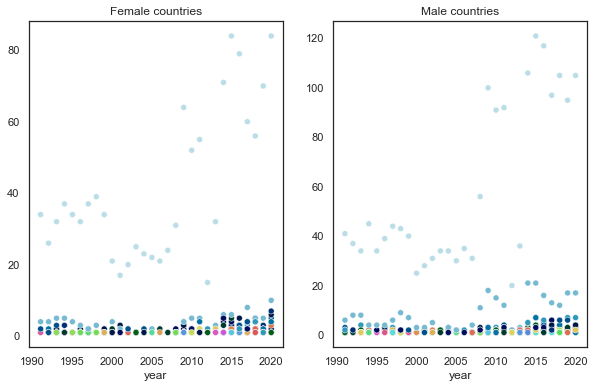

In [26]:
#f_df.plot(x="year",y="workCount",kind="scatter", color="country")
fig,ax=plt.subplots(1, 2, figsize=(10,6))#

x= f_df["year"] 
y1 = f_df["workCount"]

#ax.scatter(x,y1, label="not annotated", color=)
ax[0]=sns.scatterplot(data=f_df,x="year",y="workCount",hue='country',palette=color_map, sizes=(1, 800),ax=ax[0])
ax[0].legend([],[], frameon=False)
ax[0].set_title("Female countries")
ax[0].set_xlabel("year")
ax[0].set_ylabel("")



ax[1]=sns.scatterplot(data=m_df,x="year",y="workCount" ,hue='country',palette=color_map,sizes=(1, 800), ax=ax[1])
ax[1].legend([],[], frameon=False)
ax[1].set_title("Male countries")
ax[1].set_xlabel("year")
ax[1].set_ylabel("")

In [27]:
f.serialize(destination="../../data/geotags_novels_fin_countries.nt",format="nt")

/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/rdflib/plugins/serializers/nt.py:36: UserWarning: NTSerializer always uses UTF-8 encoding. Given encoding was: None
  warnings.warn(


<Graph identifier=N6b52a48fb34d4a0f988ab09febb6f89c (<class 'rdflib.graph.Graph'>)>

## correct things in theme graph

In [44]:
# cluster per genre information
# load genre graphs
l = Graph() 
l.parse("../../data/finnish_genre_theme.nt",format="nt")

k = Graph() 
k.parse("../../data/translated_genre_theme.nt",format="nt")

<Graph identifier=N5dfcfa9489f14d8fa8cf9daab2c991a1 (<class 'rdflib.graph.Graph'>)>

In [45]:
# initial language lookup

qres = k.query("""
#PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?lang
WHERE {
  ?teos a rel:novel ; rel:langOrig ?lang. 
  
}  """)

langlabel_lookup = {}

for l in qres:
    lang=l["lang"].toPython()
    #print(lang)
    if lang not in langlabel_lookup.keys():
        langlabel_lookup[lang]= lang.split("/")[-1]
    else:
        print("oop",lang)

In [46]:
#
print(langlabel_lookup.items())

dict_items([('http://lexvo.org/id/iso639-3/eng', 'eng'), ('http://lexvo.org/id/iso639-3/ita', 'ita'), ('http://lexvo.org/id/iso639-3/deu', 'deu'), ('http://lexvo.org/id/iso639-3/isl', 'isl'), ('http://lexvo.org/id/iso639-3/swe', 'swe'), ('http://lexvo.org/id/iso639-3/rus', 'rus'), ('http://lexvo.org/id/iso639-3/fra', 'fra'), ('http://lexvo.org/id/iso639-3/dan', 'dan'), ('http://lexvo.org/id/iso639-3/spa', 'spa'), ('http://lexvo.org/id/iso639-3/tur', 'tur'), ('http://lexvo.org/id/iso639-3/ces', 'ces'), ('http://lexvo.org/id/iso639-3/por', 'por'), ('http://lexvo.org/id/iso639-3/nor', 'nor'), ('http://lexvo.org/id/iso639-3/hin', 'hin'), ('http://lexvo.org/id/iso639-3/kor', 'kor'), ('http://lexvo.org/id/iso639-3/lav', 'lav'), ('http://lexvo.org/id/iso639-3/est', 'est'), ('http://lexvo.org/id/iso639-3/yid', 'yid'), ('http://lexvo.org/id/iso639-3/hun', 'hun'), ('http://lexvo.org/id/iso639-3/nld', 'nld'), ('http://lexvo.org/id/iso639-3/pol', 'pol'), ('http://lexvo.org/id/iso639-3/kat', 'kat')

In [49]:
oldlang=[]
for key,v in langlabel_lookup.items():
    if "lexvo" not in key:
        print(key,v)
        oldlang.append(key)

http://www.lingvoj.org/lang/be-x-old be-x-old
http://www.lingvoj.org/lang/bnt bnt
http://www.lingvoj.org/lang/smi smi
http://www.lingvoj.org/lang/en-gb en-gb
http://www.lingvoj.org/lang/fiu fiu


In [50]:
for key,v in langlabel_lookup.items():
    if "vec" in key:
        print(key,v)

http://lexvo.org/id/iso639-3/vec vec


In [51]:
# correct list
# smi http://www.lexvo.org/page/iso639-5/smi
# en-gb http://lexvo.org/id/iso639-3/eng
# bnt http://www.lexvo.org/page/iso639-5/bnt
# fiu http://www.lexvo.org/page/iso639-5/fiu
# be-x-old http://www.lexvo.org/page/iso639-3/bel
# 'http://lexvo.org/id/iso639-3/vec': 'vec',

#newlang=["http://www.lexvo.org/page/iso639-5/smi","http://lexvo.org/id/iso639-3/eng","http://www.lexvo.org/page/iso639-5/bnt",
#        "http://www.lexvo.org/page/iso639-5/fiu","http://www.lexvo.org/page/iso639-3/bel"]
#updated= ["http://lexvo.org/page/iso639-5/smi","http://lexvo.org/id/iso639-3/eng","http://lexvo.org/page/iso639-5/bnt",
#        "http://lexvo.org/page/iso639-5/fiu","http://lexvo.org/page/iso639-3/bel"]
updated= ["http://lexvo.org/page/iso639-5/smi","http://lexvo.org/id/iso639-3/eng","http://lexvo.org/page/iso639-5/bnt",
        "http://lexvo.org/page/iso639-5/fiu"]
newlang={"http://www.lingvoj.org/lang/be-x-old":"http://lexvo.org/page/iso639-3/bel","http://www.lingvoj.org/lang/bnt":"http://lexvo.org/page/iso639-5/bnt","http://www.lingvoj.org/lang/smi":"http://lexvo.org/id/iso639-5/smi","http://www.lingvoj.org/lang/fiu":"http://www.lexvo.org/page/iso639-5/fiu","http://www.lingvoj.org/lang/en-gb":"http://lexvo.org/id/iso639-3/eng","http://lexvo.org/id/iso639-3/vec":'http://lexvo.org/id/iso639-3/rus'}

In [52]:
for key,val in newlang.items():
    
    print(key,val)
    old= key
    new=val.replace("page","id")
    print(old,new)
    query="""
    PREFIX rel: <http://ldf.fi/relse/>
             DELETE {?teos rel:langOrig <OLD> }
             INSERT { ?teos rel:langOrig  <NEW> }
             WHERE { ?teos rel:langOrig <OLD> }
             """
    q=query.replace("OLD",old).replace("NEW",new)
    k.update(q)
    #print("After second update:")
    

http://www.lingvoj.org/lang/be-x-old http://lexvo.org/page/iso639-3/bel
http://www.lingvoj.org/lang/be-x-old http://lexvo.org/id/iso639-3/bel
http://www.lingvoj.org/lang/bnt http://lexvo.org/page/iso639-5/bnt
http://www.lingvoj.org/lang/bnt http://lexvo.org/id/iso639-5/bnt
http://www.lingvoj.org/lang/smi http://lexvo.org/id/iso639-5/smi
http://www.lingvoj.org/lang/smi http://lexvo.org/id/iso639-5/smi
http://www.lingvoj.org/lang/fiu http://www.lexvo.org/page/iso639-5/fiu
http://www.lingvoj.org/lang/fiu http://www.lexvo.org/id/iso639-5/fiu
http://www.lingvoj.org/lang/en-gb http://lexvo.org/id/iso639-3/eng
http://www.lingvoj.org/lang/en-gb http://lexvo.org/id/iso639-3/eng
http://lexvo.org/id/iso639-3/vec http://lexvo.org/id/iso639-3/rus
http://lexvo.org/id/iso639-3/vec http://lexvo.org/id/iso639-3/rus


In [53]:
# save
k.serialize(destination="../../data/foreign_theme_genre.nt",format="nt")


/u/98/peurat1/unix/kirjasampo/benv/lib/python3.8/site-packages/rdflib/plugins/serializers/nt.py:36: UserWarning: NTSerializer always uses UTF-8 encoding. Given encoding was: None
  warnings.warn(


<Graph identifier=N5dfcfa9489f14d8fa8cf9daab2c991a1 (<class 'rdflib.graph.Graph'>)>